In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from utils import segpath2path, point2segments

NOTE: effectively no obstacle avoidance in the data below

In [2]:
ls_model_name = 'pure-pursuit', 'differential-MB', 'klinokinesis-MB'
ls_model_dir = 'gridsearch-routefollow/pure-pursuit', 'acain/vary_crot/lamb_vary_crot', 'gridsearch-routefollow/umbkli/switch_step5'


ls_value = 0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 50
ls_rot_coeff = ls_value

ls_color = 'tab:blue', 'tab:green', 'tab:red'
goal_idx = -1
catchment_radius = 0.372 / 2 ## 0.372 is the wheel axle length of Freight

n_condition, n_trial = len(ls_value), 100
n_epoch_train, n_epoch_test = 125, 500

In [3]:
data_path = {}
for model_name in ls_model_name:
    data_path[model_name] = {'train': [], 'test': []}

for record_dir, model_name in zip(ls_model_dir, ls_model_name):
    val_name = 'crot' if model_name == 'differential-MB' else 'rot_coeff'
    for val in ls_value:        
        data_dir = os.path.join('records', record_dir, '{}{}'.format(val_name, val))
        for trial_idx, trial_dir in enumerate(sorted(os.listdir(data_dir))[:n_trial]):
            path = {'test': None, 'train': None}
            ### load path data          
            for phase in ('train', 'test'):
                data_file = os.path.join(data_dir, trial_dir, 'Freight_{}_0_record.npz'.format(phase))
                try:
                    path = np.array([np.load(data_file)[arg] for arg in 'xy'])
                    if phase == 'test' and path.shape[1] < n_epoch_test:
                        path = np.pad(path, ((0, 0), (0, 500 - path.shape[1])), constant_values=np.nan)
                except:
                    print("The file {} does not exist.".format(data_file))
                data_path[model_name][phase].append(path)
    
for model_name in ls_model_name:
    for phase, n_epoch in zip(('train', 'test'), (n_epoch_train, n_epoch_test)):
        data_path[model_name][phase] = np.reshape(data_path[model_name][phase], (n_condition, n_trial, 2, n_epoch))
        
# np.save(os.path.join('records/gridsearch-routefollow/', 'data_path.npy'), data_path)

[Text(-100.0, 0, ''),
 Text(0.0, 0, ''),
 Text(100.0, 0, ''),
 Text(200.0, 0, ''),
 Text(300.0, 0, ''),
 Text(400.0, 0, '')]

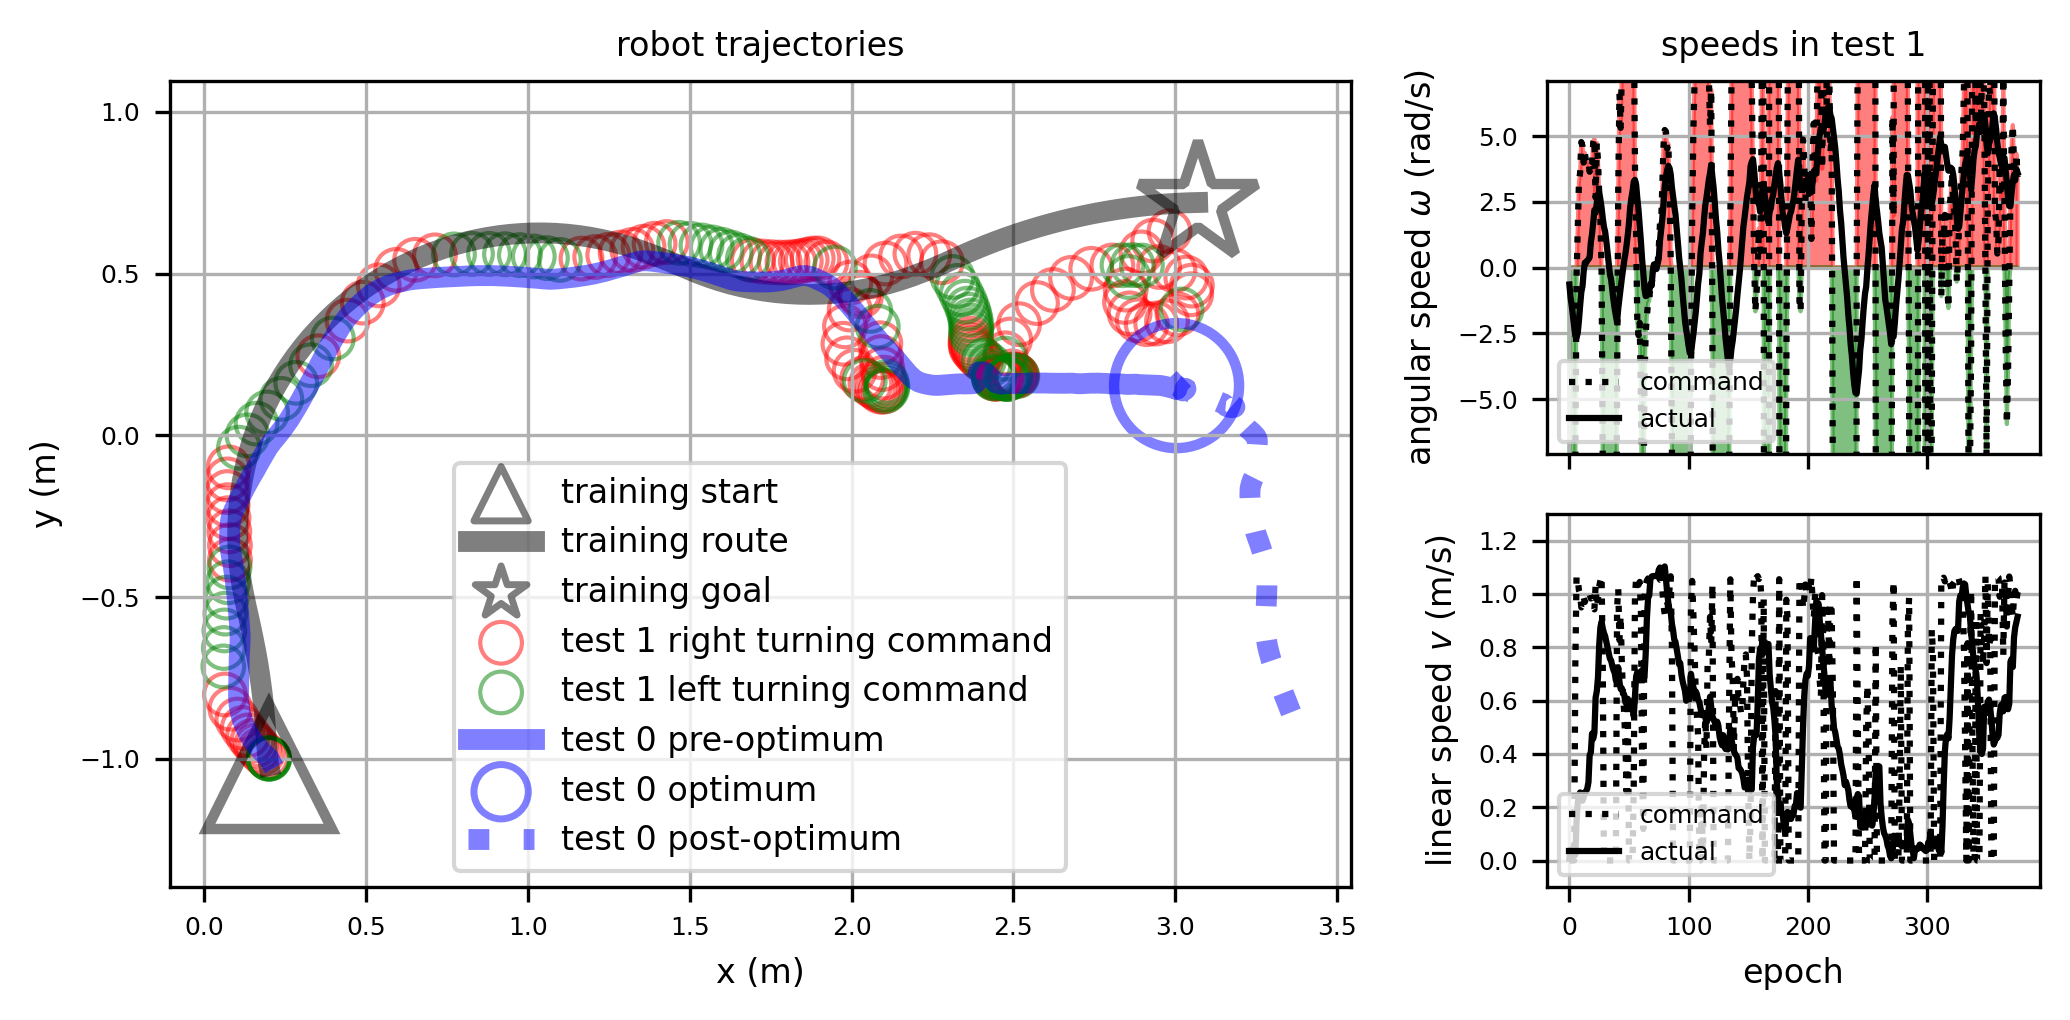

In [33]:
model_name == 'differential-MB'
val_name = 'crot'
val = 10

fig, ax = plt.subplot_mosaic('''
                                AAB
                                AAC
                                ''', figsize=(7, 3.5), dpi=300, layout='tight')

lw = 5
alpha = 0.5

####
ax['A'].scatter([], [], label='training start',
                edgecolor='k', lw=lw/3, marker='^', facecolor='none', s=170, alpha=0.5)
ax['A'].plot([], [], c='k', lw=lw, alpha=0.5, label='training route')
ax['A'].scatter([], [], label='training goal',
                edgecolor='k', lw=lw/3, marker='*', facecolor='none', s=170, alpha=0.5)


#########
    

data_dir = os.path.join('records', ls_model_dir[1], '{}{}'.format(val_name, val))
trial_dir = sorted(os.listdir(data_dir))[10]

for phase in ('train', 'test'):
    data_file = os.path.join(data_dir, trial_dir, 'Freight_{}_0_record.npz'.format(phase))

    x, y = np.array([np.load(data_file)[arg] for arg in 'xy'])
    va, vat, vl, vlt = [np.load(data_file, allow_pickle=True)['extra'][()][key] for key in ('v_ang', 'v_ang_true', 'v_lin', 'v_lin_true')]
 
    if phase == 'train':
        ax['A'].plot(-y, x, c='k', lw=lw, alpha=0.5)
        ax['A'].plot(-y[0], x[0], marker='^', c='k', mfc='none', markersize=30, markeredgewidth=lw/2, alpha=alpha)
        ax['A'].plot(-y[-1], x[-1], marker='*', c='k', mfc='none', markersize=30, markeredgewidth=lw/2, alpha=alpha)
        goal_x, goal_y = x[-1], y[-1]

    else:
        right_mask = va > 0
        left_mask = va <= 0
        epochs = np.arange(right_mask.size)
        ax['A'].scatter(-y[right_mask][::2], x[right_mask][::2], label='test 1 right turning command',
                        edgecolor='r', facecolor='none', 
                        s=100, alpha=0.5)
        ax['A'].scatter(-y[left_mask][::2], x[left_mask][::2], label='test 1 left turning command',
                        edgecolor='g', facecolor='none', 
                        s=100, alpha=0.5)
        
        va_max = 11.469
        ax['B'].plot(va * va_max, c='k', ls='dotted', label='command')
        ax['B'].plot(vat, c='k', label='actual')
        ax['B'].set_ylim(-7.1, 7.1)
        
        vl_max = 2.133
        ax['C'].plot(vl * vl_max, c='k', ls='dotted', label='command')
        ax['C'].plot(vlt, c='k', label='actual')
        ax['C'].set_ylim(-0.1, 1.3)
        
        for ak in 'B':
            ax[ak].fill_between(epochs, 0, va * va_max * right_mask, color='r', alpha=0.5)
            ax[ak].fill_between(epochs, 0, va * va_max * left_mask, color='g', alpha=0.5)
        
    

###########


trial_dir = sorted(os.listdir(data_dir))[11] #7

data_file = os.path.join(data_dir, trial_dir, 'Freight_{}_0_record.npz'.format(phase))

x, y = np.array([np.load(data_file)[arg] for arg in 'xy'])

idx_min2goal = np.argmin(np.linalg.norm(np.array([x - goal_x, y - goal_y]), axis=0))

ax['A'].plot(-y[:idx_min2goal], x[:idx_min2goal], c='b', lw=lw, alpha=0.5, label='test 0 pre-optimum')

ax['A'].scatter([], [], label='test 0 optimum',
                edgecolor='b', lw=lw/3, marker='o', facecolor='none', s=170, alpha=0.5)

ax['A'].plot(-y[idx_min2goal:], x[idx_min2goal:], c='b', lw=lw, alpha=0.5, ls='dotted', label='test 0 post-optimum')
ax['A'].scatter(-y[idx_min2goal], x[idx_min2goal], edgecolor='b', lw=lw/2, 
            marker='o', facecolor='none', s=900, alpha=0.5)


######
    
    
ax['A'].set_aspect('equal', adjustable='datalim')

for ak, xlab, ylab in zip('ABC', 
                          ('x (m)', '', 'epoch'),
                          ('y (m)', 'angular speed $\omega$ (rad/s)', 'linear speed $v$ (m/s)')):
    ax[ak].grid()
    ax[ak].set_xlabel(xlab, fontsize=8)
    ax[ak].set_ylabel(ylab, fontsize=8)
    ax[ak].xaxis.set_tick_params(labelsize=6)
    ax[ak].yaxis.set_tick_params(labelsize=6)
    
    
ax['A'].legend(fontsize=8)
for ak in 'BC':
    ax[ak].legend(loc=3, fontsize=6)

    #############
    

ax['A'].set_title('robot trajectories', fontsize=8)
ax['B'].set_title('speeds in test 1', fontsize=8)
ax['B'].set_xticklabels([])


In [3]:
data_path = np.load(os.path.join('records/gridsearch-routefollow/', 'data_path.npy'), allow_pickle=True)[()]

for model in data_path.keys():
    for phase in ('train', 'test'):
        data_path[model][phase] = (data_path[model][phase].T - data_path[model][phase][:, :, :, 0].T).T
        
np.save(os.path.join('records', record_dir, 'data_path.npy'), data_path)

In [4]:
data_dist_test2goal, data_min_dist2goal, data_time_min_dist2goal = {}, {}, {}
data_dist_testtrunc2goal = {}

for model_name in ls_model_name:
    path_train_init = data_path[model_name]['train'][:, :, :, 0]
    path_train_goal = data_path[model_name]['train'][:, :, :, -1]
    dist_init2goal = np.linalg.norm(path_train_goal - path_train_init, axis=-1)
    dist_test2goal = np.linalg.norm(path_train_goal[:, :, :, np.newaxis] - data_path[model_name]['test'], axis=2)
    time_min_dist2goal = np.argmin(dist_test2goal, axis=2)
    min_dist2goal = np.min(dist_test2goal, axis=2)
    
    data_dist_test2goal[model_name] = dist_test2goal
    data_min_dist2goal[model_name] = min_dist2goal
    data_time_min_dist2goal[model_name] = time_min_dist2goal
    
    nan_mask = (time_min_dist2goal.T < np.tile(np.arange(n_epoch_test), (n_condition, n_trial, 1)).T).T
    nan_mask_path = np.moveaxis(np.tile(nan_mask, (2, 1, 1, 1)), 0, 2)
    data_dist_testtrunc2goal[model_name] = np.where(nan_mask, np.nan, dist_test2goal)
    data_path[model_name]['test_trunc'] = np.where(nan_mask_path, np.nan, data_path[model_name]['test'])

In [5]:
data_dist_test2path, data_dist_test2line = {}, {}

for model_name in ls_model_name:
    model_dist_test2path, model_dist_test2line = [], []
    for path_train_val, path_test_val in zip(data_path[model_name]['train'], data_path[model_name]['test_trunc']):
        val_dist_test2path, val_dist_test2line = [], []
        for path_train_trial, path_test_trial in zip(path_train_val, path_test_val):
            dist_test2path = [point2segments(xy, path_train_trial.T) for xy in path_test_trial.T]
            val_dist_test2path.append(dist_test2path)
            dist_test2line = [point2segments(xy, path_train_trial.T[[0, -1]]) for xy in path_test_trial.T]
            val_dist_test2line.append(dist_test2line)
        model_dist_test2line.append(val_dist_test2line)
        model_dist_test2path.append(val_dist_test2path)
        
    data_dist_test2path[model_name] = np.array(model_dist_test2path)
    data_dist_test2line[model_name] = np.array(model_dist_test2line)

# path
## all path

NameError: name 'xx' is not defined

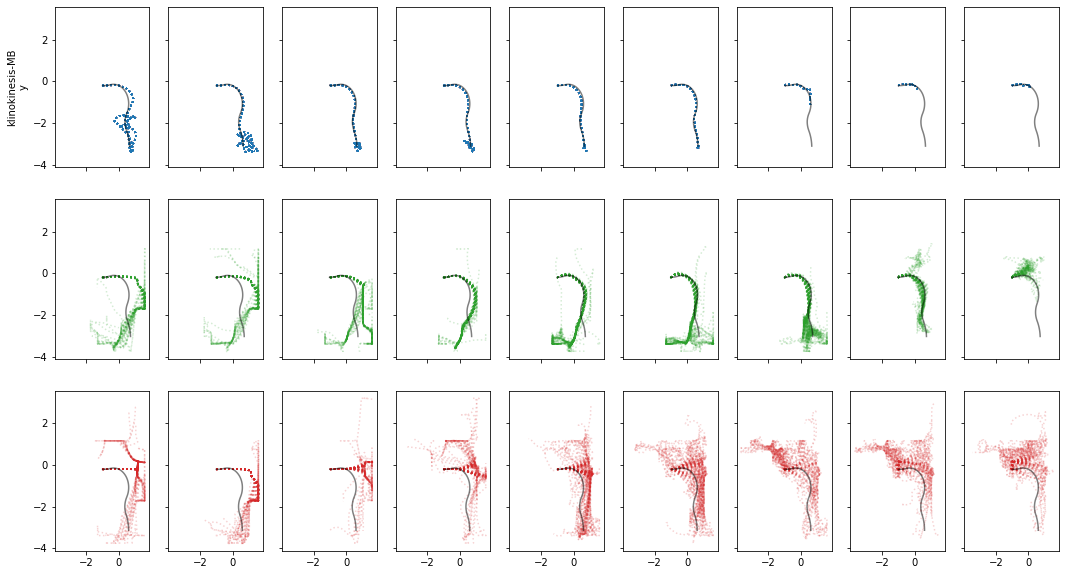

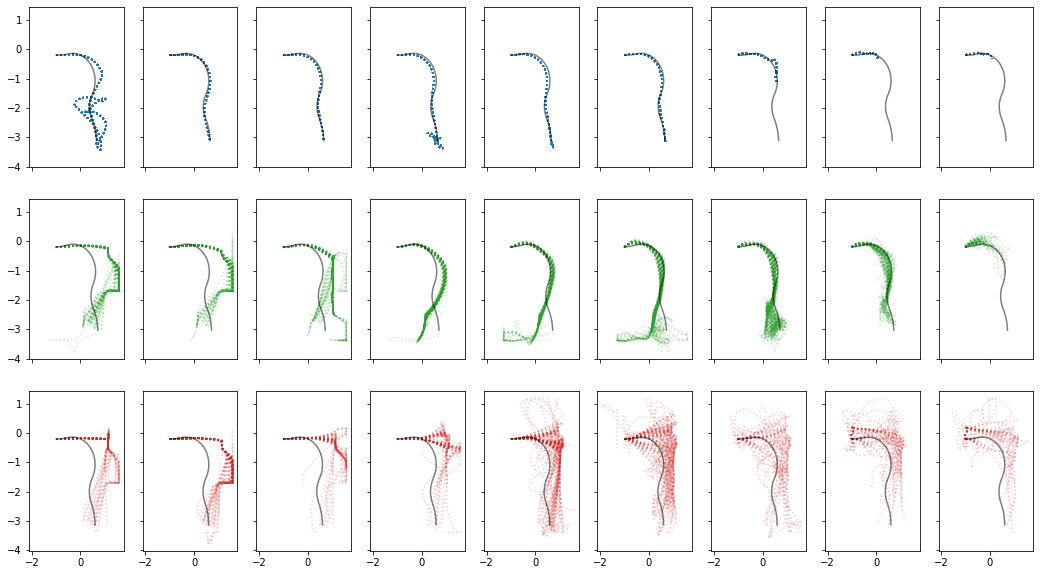

In [5]:
fig, axes = plt.subplots(3, n_condition, sharex=True, sharey=True, figsize=(18, 10))
fig, bxes = plt.subplots(3, n_condition, sharex=True, sharey=True, figsize=(18, 10))

for model_name, axrow, bxrow, color in zip(ls_model_name, axes, bxes, ls_color):
    for dtp_train, dtp_test, dtp_testtrunc, val, ax, bx in zip(data_path[model_name]['train'], 
                                                            data_path[model_name]['test'], 
                                                            data_path[model_name]['test_trunc'],
                                                            ls_value, axrow, bxrow):
        for trial_idx, (path_train, path_test, path_test_trunc) in enumerate(zip(dtp_train, dtp_test, dtp_testtrunc)):
            if trial_idx % 1 == 0:
                ax.plot(*path_test, c=color, alpha=0.2, ls='dotted')
                bx.plot(*path_test_trunc, c=color, alpha=0.2, ls='dotted')
        
        ax.plot(*path_train[:, :goal_idx], c='k', alpha=0.5)
        bx.plot(*path_train[:, :goal_idx], c='k', alpha=0.5)


for xes in (axes, bxes):
    for xrow in xes:
        xrow[0].set_ylabel('{}\ny'.format(model_name))
        for xr, val in zip(xrow, ls_value):
            xx.set_xlabel('x')
            xx.set_ylabel('y')
            xx.set_aspect('equal')    
            xx.set_title(val)
            xx.grid()

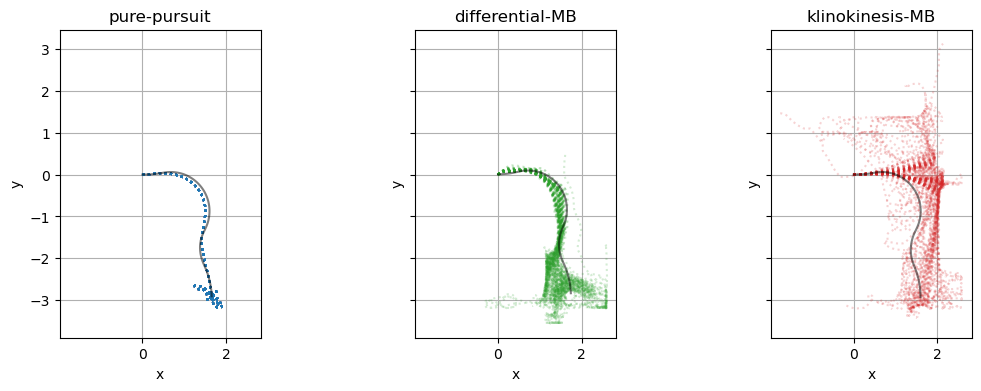

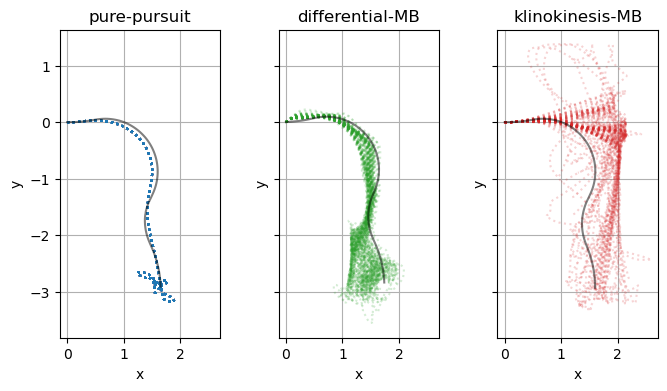

In [11]:
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(13, 4))
fig, bxes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(8, 4))
for model_name, ax, bx, color, val, ax in zip(ls_model_name, axes, bxes, ls_color, (1, 10, 2), axes):
    val_idx = np.nonzero(np.array(ls_rot_coeff) == val)[0][0]
    dtp_train, dtp_test, dtp_test_trunc = [data_path[model_name][phase][val_idx] for phase in ('train', 'test', 'test_trunc')]
    for trial_idx, (path_train, path_test, path_test_trunc) in enumerate(zip(dtp_train, dtp_test, dtp_test_trunc)):
        if trial_idx % 1 == 0:
            ax.plot(*path_test, c=color, alpha=0.2, ls='dotted')
            bx.plot(*path_test_trunc, c=color, alpha=0.2, ls='dotted')

    ax.plot(*path_train[:, :goal_idx], c='k', alpha=0.5)
    bx.plot(*path_train[:, :goal_idx], c='k', alpha=0.5)

    for xx in (ax, bx):
        xx.set_xlabel('x')
        xx.set_ylabel('y')
        xx.set_aspect('equal')    
        xx.set_title(model_name)
        xx.grid()
        


## average path

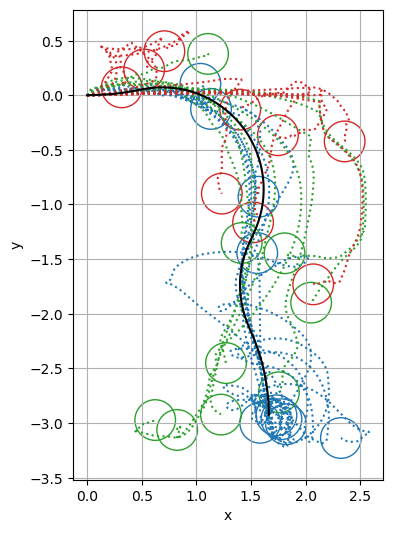

In [78]:
fig, ax = plt.subplots(figsize=(4, 7))

ls_alpha = np.linspace(0.1, 1, n_condition)

mean_train_path = []
for phase in ('test', 'train'):
    for model_name, test_color in zip(ls_model_name, ls_color):
        mean_path = np.mean(data_path[model_name][phase], axis=1)
        if phase == 'test':
            for val, mp, al in zip(ls_value, mean_path, ls_alpha):            
                ax.plot(*mp, color=test_color, ls='dotted')
                last_num_idx = np.max(np.nonzero(~np.isnan(mp[0])))
#                 ax.scatter(*mp[:, last_num_idx], edgecolor=test_color, facecolor='none', lw=3, s=600)
                ax.add_patch(mpatches.Circle(mp[:, last_num_idx], catchment_radius, 
                                             edgecolor=test_color, facecolor='none'))
        else:
            mean_train_path.append(np.mean(mean_path, axis=0))
                
ax.plot(*np.mean(mean_train_path, axis=0), color='k')
    
# for ax, val in zip(axes.flatten(), ls_value):
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_aspect('equal')    
ax.grid()

C:\Users\anish\anaconda3\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: Mean of empty slice
C:\Users\anish\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1396: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


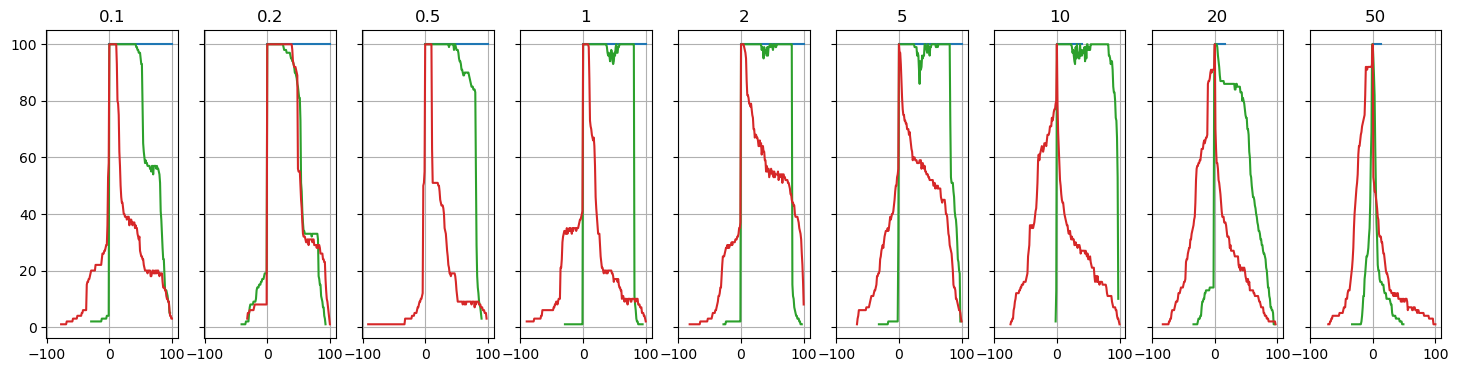

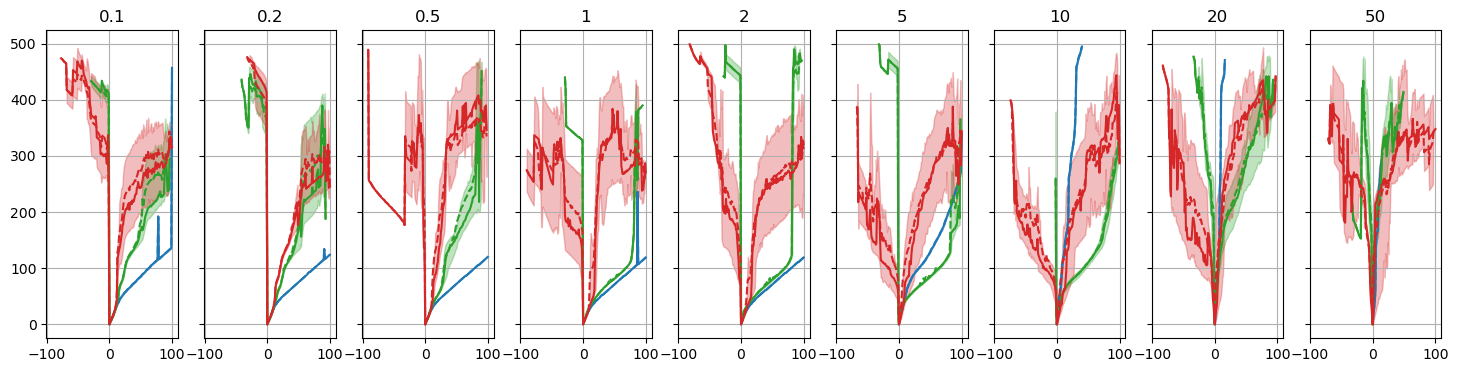

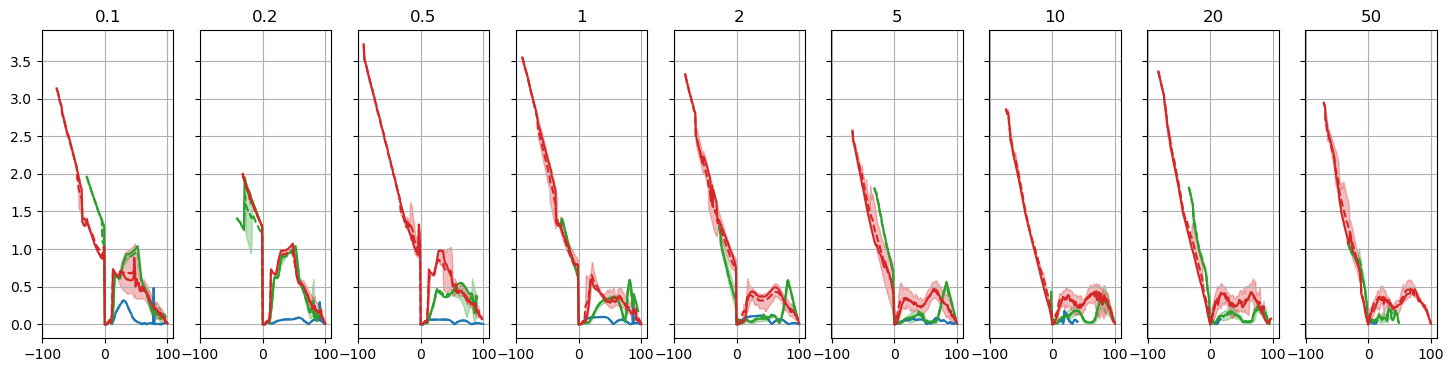

In [7]:
data_step75 = {}

fig, bxes = plt.subplots(1, n_condition, figsize=(18, 4), sharey=True, sharex=True)
fig, cxes = plt.subplots(1, n_condition, figsize=(18, 4), sharey=True, sharex=True)
fig, axes = plt.subplots(1, n_condition, figsize=(18, 4), sharey=True, sharex=True)

for model_name, color in zip(ls_model_name, ls_color):
    data_step75[model_name] = {'n_reach': [], 'progress_time': [], 'test2path': []}
    for ax, bx, cx, val, dist_test2goal, dist_test2path in zip(axes.flatten(), bxes.flatten(), cxes.flatten(), ls_value, 
                                                           data_dist_test2goal[model_name], 
                                                           data_dist_test2path[model_name]):
        progress = np.rint((1 - np.divide(dist_test2goal.T, dist_test2goal[:, 0]).T) * 100)
        progress_step = np.arange(np.nanmin(progress), np.nanmax(progress) + 1)

        val_test2path, val_n_point = [], []
        val_ptime = []
        for trial_progress, trial_test2path in zip(progress, dist_test2path):
            px, pxidx = np.unique(trial_progress, return_index=True)
            t2p_interp = np.interp(progress_step, px, trial_test2path[pxidx], left=np.nan, right=np.nan)
            
            ptime = np.full_like(progress_step, np.nan)
            ptime[(px[~np.isnan(px)] - np.min(progress_step)).astype(int)] = pxidx[~np.isnan(px)]
            
            val_test2path.append(t2p_interp)
            val_n_point.extend(px)
            val_ptime.append(ptime)
            
        t2p_avg = np.nanmean(val_test2path, axis=0)
        t2p_lo, t2p_med, t2p_hi = np.nanquantile(val_test2path, (0.25, 0.5, 0.75), axis=0)
            
        ax.plot(progress_step, t2p_avg, color=color, ls='dashed')
        ax.plot(progress_step, t2p_med, color=color)        
        ax.fill_between(progress_step, t2p_lo, t2p_hi, color=color, alpha=0.3)
        
        p_reach, n_reach = np.unique(val_n_point, return_counts=True)
        bx.plot(p_reach, n_reach, color=color)
        
        ptime_avg = np.nanmean(val_ptime, axis=0)
        ptime_lo, ptime_med, ptime_hi = np.nanquantile(val_ptime, (0.25, 0.5, 0.75), axis=0)
        cx.plot(progress_step, ptime_avg, color=color, ls='dashed')
        cx.plot(progress_step, ptime_med, color=color)
        cx.fill_between(progress_step, ptime_lo, ptime_hi, color=color, alpha=0.3)
        
        p_step75 = int(95 - progress_step[0])
        if p_step75 < progress_step.size:
            data_step75[model_name]['test2path'].append([t2p_avg[p_step75], t2p_lo[p_step75], t2p_med[p_step75], t2p_hi[p_step75]])
            data_step75[model_name]['progress_time'].append([ptime_avg[p_step75], ptime_lo[p_step75], ptime_med[p_step75], ptime_hi[p_step75]])
        else:
            data_step75[model_name]['test2path'].append([np.nan, np.nan, np.nan, np.nan])
            data_step75[model_name]['progress_time'].append([np.nan, np.nan, np.nan, np.nan])
            
        
        if np.count_nonzero(p_reach == 95) == 0:
            data_step75[model_name]['n_reach'].append(np.nan)
        else:
            r_step75 = np.nonzero(p_reach == 95)[0][0]
            data_step75[model_name]['n_reach'].append(n_reach[r_step75])
        
for ax, bx, cx, val in zip(axes.flatten(), bxes.flatten(), cxes.flatten(), ls_rot_coeff):
#     ax.set_ylim(0, 2)
    for axx in (ax, bx, cx):
#         axx.set_xlim(-10, 100)
        axx.set_title(val)
        axx.grid()

<ipython-input-8-97a83dee13b8>:53: RuntimeWarning: Mean of empty slice
  ax.plot(progress_step, np.nanmean(val_test2path, axis=0), color=color, ls='dashed')
/home/yihelu/miniconda3/envs/python3.8/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/home/yihelu/miniconda3/envs/python3.8/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
<ipython-input-8-97a83dee13b8>:61: RuntimeWarning: Mean of empty slice
  cx.plot(progress_step, np.nanmean(val_ptime, axis=0), color=color, ls='dashed')
/home/yihelu/miniconda3/envs/python3.8/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/home/yihelu/miniconda3/envs/python3.8/lib/python3.8/site-packa

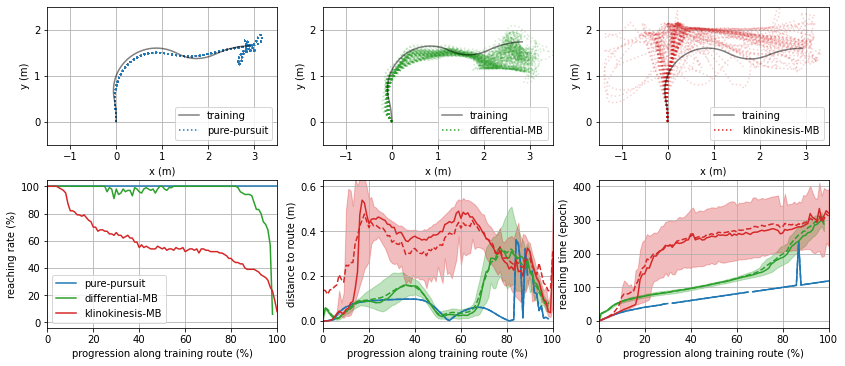

In [8]:
fig, axes = plt.subplots(2, 3, figsize=(14, 6), sharex='row')


for model_name, ax, color, val in zip(ls_model_name, axes[0], ls_color, (1, 10, 2)):
    val_idx = np.nonzero(np.array(ls_rot_coeff) == val)[0][0]
    dtp_train, dtp_test, dtp_test_trunc = [data_path[model_name][phase][val_idx] for phase in ('train', 'test', 'test_trunc')]
    for trial_idx, (path_train, path_test, path_test_trunc) in enumerate(zip(dtp_train, dtp_test, dtp_test_trunc)):
        if trial_idx % 1 == 0:
            ax.plot(-(path_test_trunc[1] - path_test_trunc[1,0]), path_test_trunc[0] - path_test_trunc[0,0], 
                    c=color, alpha=0.2, ls='dotted')

    ax.plot(-(path_train[:, :goal_idx][1] - path_train[:, :goal_idx][1,0]), 
            path_train[:, :goal_idx][0] - path_train[:, :goal_idx][0,0], 
            c='k', alpha=0.5, label='training')
    ax.plot([], [], c=color, ls='dotted', label=model_name)

    ax.set_xlabel('x (m)')
    ax.set_ylabel('y (m)')
    ax.set_xticks(np.arange(-1, 3.1, 1))
    ax.set_yticks(np.arange(0, 2.1, 1))
    ax.set_xlim(-1.5, 3.5)
    ax.set_ylim(-0.5, 2.5)
    ax.set_aspect('equal')    
    ax.legend(loc=4)
    ax.grid()


bx, ax, cx = axes[1]
for model_name, color, val in zip(ls_model_name, ls_color, (1, 10, 2)):
    val_idx = np.nonzero(np.array(ls_rot_coeff) == val)[0][0]

    dist_test2goal, dist_test2path = data_dist_test2goal[model_name][val_idx], data_dist_test2path[model_name][val_idx]
    progress = np.rint((1 - np.divide(dist_test2goal.T, dist_test2goal[:, 0]).T) * 100)
    progress_step = np.arange(np.nanmin(progress), np.nanmax(progress) + 1)

    val_test2path, val_n_point = [], []
    val_ptime = []
    for trial_progress, trial_test2path in zip(progress, dist_test2path):
        px, pxidx, pxinv = np.unique(trial_progress, return_index=True, return_inverse=True)
        pxinvsort = np.argsort(pxinv)
        t2p_interp = np.interp(progress_step, pxinv[pxinvsort], trial_test2path[pxinvsort], left=np.nan, right=np.nan)
        
#         px, pxidx = np.unique(trial_progress, return_index=True)
#         t2p_interp = np.interp(progress_step, px, trial_test2path[pxidx], left=np.nan, right=np.nan)
        val_test2path.append(t2p_interp)
        val_n_point.extend(px)

        ptime = np.full_like(progress_step, np.nan)
        ptime[(px[~np.isnan(px)] - np.min(progress_step)).astype(int)] = pxidx[~np.isnan(px)]
        val_ptime.append(ptime)


    ax.plot(progress_step, np.nanmean(val_test2path, axis=0), color=color, ls='dashed')
    ax.plot(progress_step, np.nanmedian(val_test2path, axis=0), color=color)

    ax.fill_between(progress_step, *np.nanquantile(val_test2path, (0.25, 0.75), axis=0), color=color, alpha=0.3)

    p_reach, n_reach = np.unique(val_n_point, return_counts=True)
    bx.plot(p_reach, n_reach, color=color, label=model_name)

    cx.plot(progress_step, np.nanmean(val_ptime, axis=0), color=color, ls='dashed')
    cx.plot(progress_step, np.nanmedian(val_ptime, axis=0), color=color)
    cx.fill_between(progress_step, *np.nanquantile(val_ptime, (0.25, 0.75), axis=0), color=color, alpha=0.3)
        
for ax, yl in zip(axes[1], ('reaching rate (%)', 'distance to route (m)', 'reaching time (epoch)')):
    ax.set_xlim(0, 100)
    ax.grid()
    ax.set_ylabel(yl)
    ax.set_xlabel('progression along training route (%)')


axes[1, 0].legend()
    
axes[1, 2].set_ylim(-20, 420)
axes[1, 2].set_yticks(np.arange(0, 401, 100))
axes[1, 1].set_ylim(-0.03, 0.63)
axes[1, 1].set_yticks(np.arange(0, 0.7, 0.2))



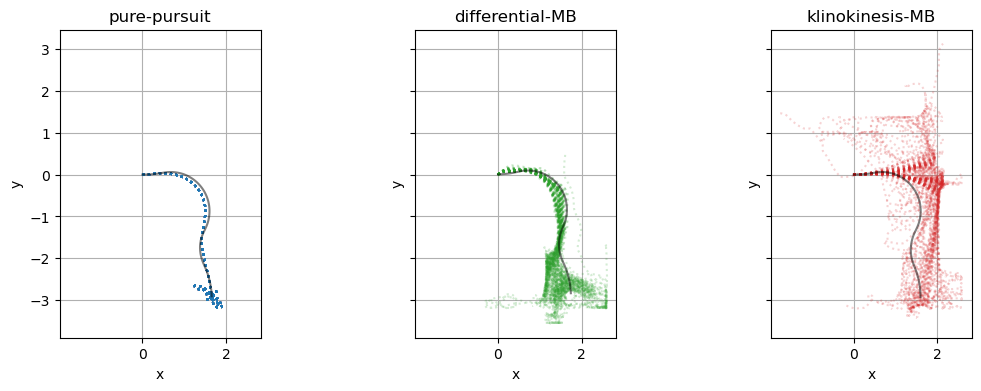

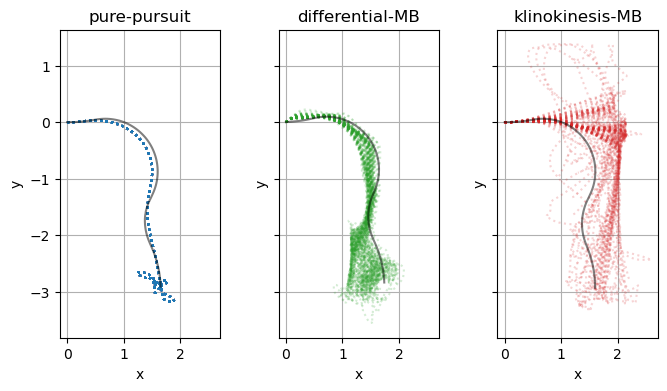

In [11]:
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(13, 4))
fig, bxes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(8, 4))
for model_name, ax, bx, color, val, ax in zip(ls_model_name, axes, bxes, ls_color, (1, 10, 2), axes):
    val_idx = np.nonzero(np.array(ls_rot_coeff) == val)[0][0]
    dtp_train, dtp_test, dtp_test_trunc = [data_path[model_name][phase][val_idx] for phase in ('train', 'test', 'test_trunc')]
    for trial_idx, (path_train, path_test, path_test_trunc) in enumerate(zip(dtp_train, dtp_test, dtp_test_trunc)):
        if trial_idx % 1 == 0:
            ax.plot(*path_test, c=color, alpha=0.2, ls='dotted')
            bx.plot(*path_test_trunc, c=color, alpha=0.2, ls='dotted')

    ax.plot(*path_train[:, :goal_idx], c='k', alpha=0.5)
    bx.plot(*path_train[:, :goal_idx], c='k', alpha=0.5)

    for xx in (ax, bx):
        xx.set_xlabel('x')
        xx.set_ylabel('y')
        xx.set_aspect('equal')    
        xx.set_title(model_name)
        xx.grid()
        


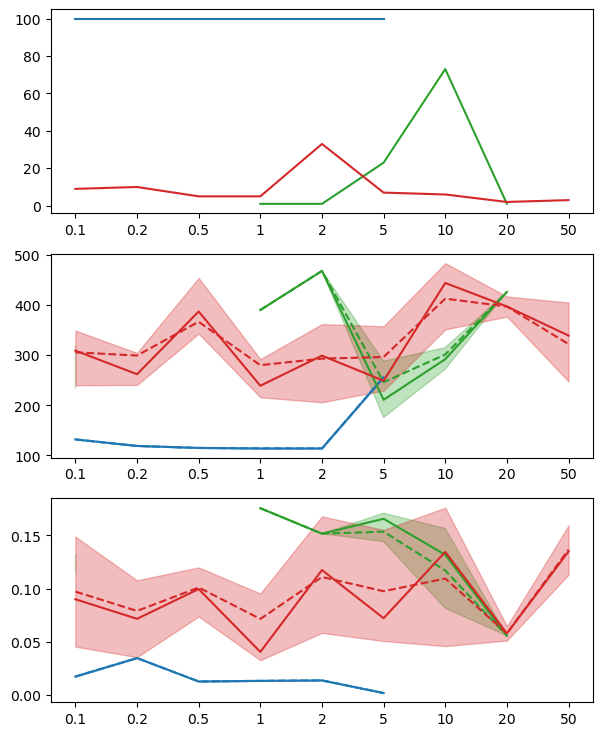

In [30]:
fig, axes = plt.subplots(3, figsize=(7, 9))

for ax, key75 in zip(axes, ('n_reach', 'progress_time', 'test2path')):
    for model_name, color in zip(ls_model_name, ls_color):
        if key75 == 'n_reach':
            y_med = data_step75[model_name][key75]
        else:
            y_avg, y_lo, y_med, y_hi = np.transpose(data_step75[model_name][key75])
            ax.fill_between(np.arange(n_condition), y_lo, y_hi, color=color, alpha=0.3)
            ax.plot(y_avg, color=color, ls='dashed')
        ax.plot(y_med, color=color)
    
    ax.set_xticks(np.arange(n_condition), ls_rot_coeff)
# ax.set_xticklabels(ls_rot_coeff)

efficiency is more important to follow long route 

# Klinokinesis is bad

record_dir = 'gridsearch-routefollow/umbkli'
ls_v_linear = 0.05, 0.1, 0.15, 0.2
ls_rot_coeff = 0.1, 0.3, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4

data_path_train, data_path_test = [], []
data_dsim_test2train = []

for rot_coeff in ls_rot_coeff:
    for v_linear in ls_v_linear:
        data_dir = os.path.join('records', record_dir, 'v_linear{}'.format(v_linear), 'rot_coeff{}'.format(rot_coeff))
        for trial_dir in os.listdir(data_dir):
            path = {'test': None, 'train': None}
            ### load path data
            for phase in ('train', 'test'):
                data_file = os.path.join(data_dir, trial_dir, 'Freight_{}_0_record.npz'.format(phase))
                try:
                    path[phase] = np.transpose([np.load(data_file)[arg] for arg in 'xy'])
                except:
                    print("The file {} does not exist.".format(data_file))

            ### process path data
            path_train_init, path_train_goal = path['train'][[0, 124]]

            dist_test2goal = np.linalg.norm(path_train_goal - path['test'], axis=1)
            time_mindist_test2goal = np.maximum(np.nanargmin(dist_test2goal), 1)
            mindist_test2goal = dist_test2goal[time_mindist_test2goal]

            dist_test2goal[time_mindist_test2goal + 1:] = np.nan
            path['test'][time_mindist_test2goal + 1:] = np.nan
            dsim_test2train = segpath2path(path['test'][:time_mindist_test2goal + 1], path['train'][:125])

            ### collect data
            data_path_train.append(path['train'].T)
            data_path_test.append(path['test'].T)
            data_dsim_test2train.append(dsim_test2train)

        
### reshape data
data_path_train, data_path_test = [np.reshape(dt, (10, 4, 10, 2, -1)) 
                                   for dt in (data_path_train, data_path_test)]

fig, axes = plt.subplots(10, 4, figsize=(18, 36), sharex=True, sharey=True)

for axrow, trainrow, testrow in zip(axes, data_path_train, data_path_test):
    for ax, traintrial, testtrial, color in zip(axrow, trainrow, testrow, ls_color):
        for train, test in zip(traintrial, testtrial):
            ax.plot(*train, c='k')
            ax.plot(*test, c=color)
            
        ax.set_aspect('equal')
        ax.set_ylim(-2, 2)

In [3]:
# data_dsim_test2train = np.reshape(data_dsim_test2train, (10, 4, 10))

# fig, axes = plt.subplots(4, 1, figsize=(18, 18), sharey=True)

# for vidx, (ax, color) in enumerate(zip(axes, ls_color)):
#     ax.plot(ls_rot_coeff, np.mean(data_dsim_test2train[:, vidx, :], axis=1), c=color)
#     for trial_dsim in data_dsim_test2train[:, vidx, :].T:
#         ax.scatter(ls_rot_coeff, trial_dsim, color=color)

In [4]:
quantile_mindist_test2goal, quantile_dsim_test2train = {}, {}
success = {}
data_success_time = {'pure-pursuit': [], 'differential-MB': [], 'klinokinesis-MB': []}

In [5]:
record_dir = 'gridsearch-routefollow/umbkli/switch_step5'
ls_rot_coeff = 0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 50

n_condition, n_trial = len(ls_rot_coeff), 100
model_name = 'klinokinesis-MB'

In [6]:
data_path_train, data_path_test = [], []
data_mindist_test2goal, data_time_mindist_test2goal, data_dsim_test2train = [], [], []

for rot_coeff in ls_rot_coeff:
    data_dir = os.path.join('records', record_dir, 'rot_coeff{}'.format(rot_coeff))
    for trial_dir in os.listdir(data_dir):
        path = {'test': None, 'train': None}
        ### load path data
        for phase in ('train', 'test'):
            data_file = os.path.join(data_dir, trial_dir, 'Freight_{}_0_record.npz'.format(phase))
            
            try:
                path[phase] = np.full((500, 2), np.nan)
                path_data = np.transpose([np.load(data_file)[arg] for arg in 'xy'])
                path[phase][:path_data.shape[0]] = path_data
            except:
                print("The file {} does not exist.".format(data_file))

        ### process path data
        path_train_init, path_train_goal = path['train'][[0, 124]]
        
#         dist_init2goal = np.linalg.norm(path_train_goal - path_train_init)
        dist_test2goal = np.linalg.norm(path_train_goal - path['test'], axis=1)
        time_mindist_test2goal = np.maximum(np.nanargmin(dist_test2goal), 1)
        time_success = np.nonzero(dist_test2goal <= catchment_radius)[0]
        if len(time_success) > 0: 
            time_mindist_test2goal = time_success[0]
            mindist_test2goal = np.nan
            success_time = time_mindist_test2goal
        else:
            mindist_test2goal = dist_test2goal[time_mindist_test2goal]
            success_time = np.nan
        
        dist_test2goal[time_mindist_test2goal + 1:] = np.nan
        path['test'][time_mindist_test2goal + 1:] = np.nan
        dsim_test2train = segpath2path(path['test'][:time_mindist_test2goal + 1], path['train'][:125])

        ### collect data
        data_path_train.append(path['train'].T)
        data_path_test.append(path['test'].T)
#         data_dist_init2goal.append(dist_init2goal)
        data_mindist_test2goal.append(mindist_test2goal)
        data_time_mindist_test2goal.append(time_mindist_test2goal)
        data_dsim_test2train.append(dsim_test2train)
        data_success_time[model_name].append(success_time)


        
### reshape data
data_path_train, data_path_test = [np.reshape(dt, (n_condition, n_trial, 2, -1)) 
                                   for dt in (data_path_train, data_path_test)]
data_mindist_test2goal, data_time_mindist_test2goal, data_dsim_test2train = [np.reshape(dt, (n_condition, n_trial)) 
                                                                             for dt in (data_mindist_test2goal, data_time_mindist_test2goal, data_dsim_test2train)]

In [7]:
success['klinokinesis-MB'] = np.count_nonzero(np.isnan(data_mindist_test2goal), axis=1)

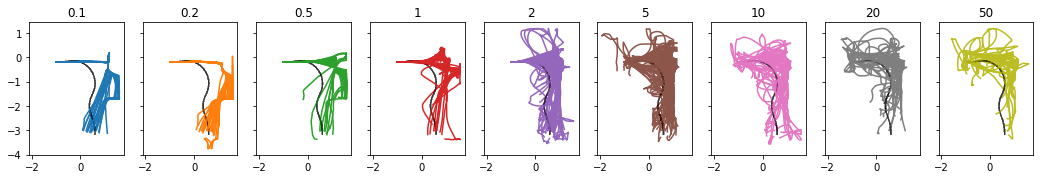

In [8]:
fig, axes = plt.subplots(1, 9, figsize=(18, 5), sharex=True, sharey=True)

for ax, rot_coeff, traintrial, testtrial, color in zip(axes, ls_rot_coeff, data_path_train, data_path_test, ls_color):
    for train, test in zip(traintrial, testtrial):
        ax.plot(*train, c='k', alpha=0.01)
        ax.plot(*test, c=color)

    ax.set_aspect('equal')
    ax.set_title(rot_coeff)

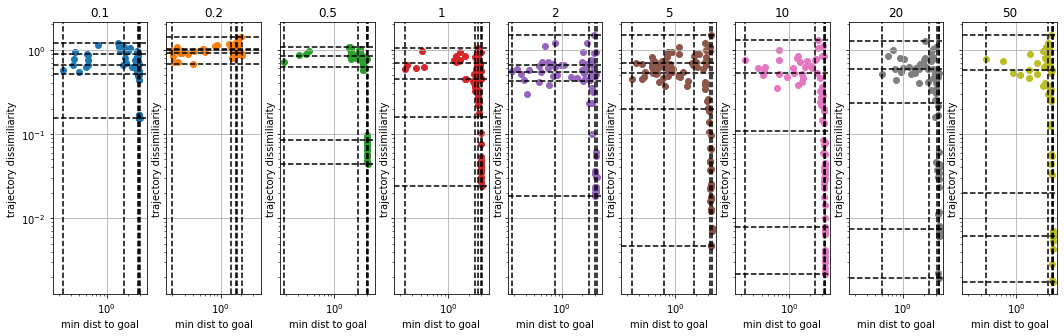

In [9]:
fig, axes = plt.subplots(1, n_condition, sharex=True, sharey=True, figsize=(18, 5))

quantile_mindist_test2goal[model_name], quantile_dsim_test2train[model_name] = [], []
for dsim, dtmd, val, ax, color in zip(data_dsim_test2train, data_mindist_test2goal, ls_rot_coeff, axes.flatten(), ls_color):
    quantile_mindist_test2goal[model_name].append(np.nanquantile(dtmd, [0, 0.25, 0.5, 0.75, 1]))
    quantile_dsim_test2train[model_name].append(np.quantile(dsim, [0, 0.25, 0.5, 0.75, 1]))
    
    [ax.axvline(mdq, color='k', ls='dashed') for mdq in quantile_mindist_test2goal[model_name][-1]]    
    [ax.axhline(mdq, color='k', ls='dashed') for mdq in quantile_dsim_test2train[model_name][-1]]
    ax.scatter(dtmd, dsim, color=color)
    
    ax.set_xlabel('min dist to goal')
    ax.set_ylabel('trajectory dissimiliarity')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title(val)
    ax.grid()

Klinokinesis is not suitable for this task: Even setting v_linear=0.0, the model cannot make the first turn

In the following 2 models, v_linear=0.5, they can both reasonably follow a route

# pure pursuit (same for naive visual localisor)

In [10]:
record_dir = 'gridsearch-routefollow/pure-pursuit'
ls_rot_coeff = 0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 50

n_condition, n_trial = len(ls_rot_coeff), 100
model_name = 'pure-pursuit'

In [11]:
data_path_train, data_path_test = [], []
data_mindist_test2goal, data_time_mindist_test2goal, data_dsim_test2train = [], [], []

for rot_coeff in ls_rot_coeff:
    data_dir = os.path.join('records', record_dir, 'rot_coeff{}'.format(rot_coeff))
    for trial_dir in os.listdir(data_dir):
        path = {'test': None, 'train': None}
        ### load path data
        for phase in ('train', 'test'):
            data_file = os.path.join(data_dir, trial_dir, 'Freight_{}_0_record.npz'.format(phase))
            
            try:
                path[phase] = np.full((500, 2), np.nan)
                path_data = np.transpose([np.load(data_file)[arg] for arg in 'xy'])
                path[phase][:path_data.shape[0]] = path_data
            except:
                print("The file {} does not exist.".format(data_file))

        ### process path data
        path_train_init, path_train_goal = path['train'][[0, 124]]
        
#         dist_init2goal = np.linalg.norm(path_train_goal - path_train_init)
        dist_test2goal = np.linalg.norm(path_train_goal - path['test'], axis=1)
        time_mindist_test2goal = np.maximum(np.nanargmin(dist_test2goal), 1)
        time_success = np.nonzero(dist_test2goal <= catchment_radius)[0]
        if len(time_success) > 0: 
            time_mindist_test2goal = time_success[0]
            mindist_test2goal = np.nan
            success_time = time_mindist_test2goal
        else:
            mindist_test2goal = dist_test2goal[time_mindist_test2goal]
            success_time = np.nan
        
        dist_test2goal[time_mindist_test2goal + 1:] = np.nan
        path['test'][time_mindist_test2goal + 1:] = np.nan
        dsim_test2train = segpath2path(path['test'][:time_mindist_test2goal + 1], path['train'][:125])

        ### collect data
        data_path_train.append(path['train'].T)
        data_path_test.append(path['test'].T)
#         data_dist_init2goal.append(dist_init2goal)
        data_mindist_test2goal.append(mindist_test2goal)
        data_time_mindist_test2goal.append(time_mindist_test2goal)
        data_dsim_test2train.append(dsim_test2train)
        data_success_time[model_name].append(success_time)


        
### reshape data
data_path_train, data_path_test = [np.reshape(dt, (n_condition, n_trial, 2, -1)) 
                                   for dt in (data_path_train, data_path_test)]
data_mindist_test2goal, data_time_mindist_test2goal, data_dsim_test2train = [np.reshape(dt, (n_condition, n_trial)) 
                                                                             for dt in (data_mindist_test2goal, data_time_mindist_test2goal, data_dsim_test2train)]

In [12]:
success['pure-pursuit'] = np.count_nonzero(np.isnan(data_mindist_test2goal), axis=1)

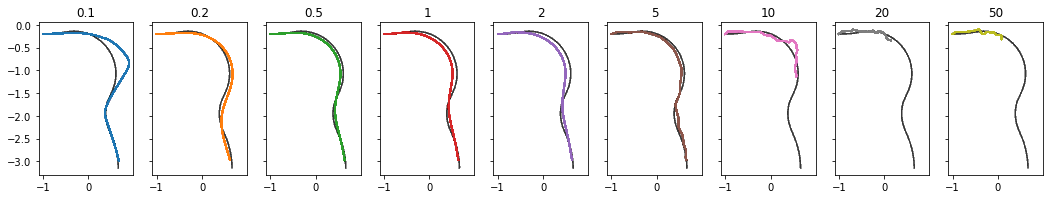

In [13]:
fig, axes = plt.subplots(1, 9, figsize=(18, 5), sharex=True, sharey=True)

for ax, rot_coeff, traintrial, testtrial, color in zip(axes, ls_rot_coeff, data_path_train, data_path_test, ls_color):
    for train, test in zip(traintrial, testtrial):
        ax.plot(*train, c='k', alpha=0.01)
        ax.plot(*test, c=color)

    ax.set_aspect('equal')
    ax.set_title(rot_coeff)

/home/yihelu/miniconda3/envs/python3.8/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1560: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,


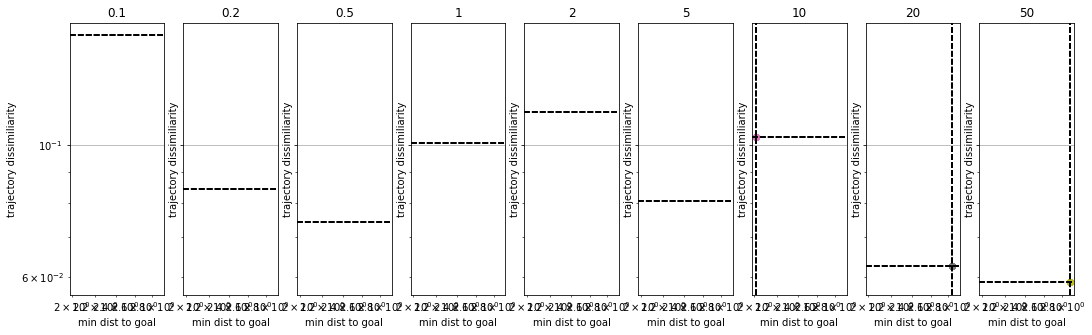

In [14]:
fig, axes = plt.subplots(1, n_condition, sharex=True, sharey=True, figsize=(18, 5))

quantile_mindist_test2goal[model_name], quantile_dsim_test2train[model_name] = [], []
for dsim, dtmd, val, ax, color in zip(data_dsim_test2train, data_mindist_test2goal, ls_rot_coeff, axes.flatten(), ls_color):
    quantile_mindist_test2goal[model_name].append(np.nanquantile(dtmd, [0, 0.25, 0.5, 0.75, 1]))
    quantile_dsim_test2train[model_name].append(np.quantile(dsim, [0, 0.25, 0.5, 0.75, 1]))
    
    [ax.axvline(mdq, color='k', ls='dashed') for mdq in quantile_mindist_test2goal[model_name][-1]]    
    [ax.axhline(mdq, color='k', ls='dashed') for mdq in quantile_dsim_test2train[model_name][-1]]
    ax.scatter(dtmd, dsim, color=color)
    
    ax.set_xlabel('min dist to goal')
    ax.set_ylabel('trajectory dissimiliarity')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title(val)
    ax.grid()

# differential MB

In [15]:
record_dir = 'acain/vary_crot/lamb_vary_crot'
ls_rot_coeff = 0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 50

n_condition, n_trial = len(ls_rot_coeff), 100
model_name = 'differential-MB'

In [16]:
data_path_train, data_path_test = [], []
data_mindist_test2goal, data_time_mindist_test2goal, data_dsim_test2train = [], [], []

for rot_coeff in ls_rot_coeff:
    data_dir = os.path.join('records', record_dir, 'crot{}'.format(rot_coeff))
    for trial_dir in os.listdir(data_dir):
        path = {'test': None, 'train': None}
        ### load path data
        for phase in ('train', 'test'):
            data_file = os.path.join(data_dir, trial_dir, 'Freight_{}_0_record.npz'.format(phase))
            
            path[phase] = np.full((500, 2), np.nan)
            path_data = np.transpose([np.load(data_file)[arg] for arg in 'xy'])
            path[phase][:path_data.shape[0]] = path_data
         

        ### process path data
        path_train_init, path_train_goal = path['train'][[0, 124]]
        
#         dist_init2goal = np.linalg.norm(path_train_goal - path_train_init)
        dist_test2goal = np.linalg.norm(path_train_goal - path['test'], axis=1)
        time_mindist_test2goal = np.maximum(np.nanargmin(dist_test2goal), 1)
        time_success = np.nonzero(dist_test2goal <= catchment_radius)[0]
        if len(time_success) > 0: 
            time_mindist_test2goal = time_success[0]
            mindist_test2goal = np.nan
            success_time = time_mindist_test2goal
        else:
            mindist_test2goal = dist_test2goal[time_mindist_test2goal]
            success_time = np.nan
                
        dist_test2goal[time_mindist_test2goal + 1:] = np.nan
        path['test'][time_mindist_test2goal + 1:] = np.nan
        dsim_test2train = segpath2path(path['test'][:time_mindist_test2goal + 1], path['train'][:125])

        ### collect data
        data_path_train.append(path['train'].T)
        data_path_test.append(path['test'].T)
#         data_dist_init2goal.append(dist_init2goal)
        data_mindist_test2goal.append(mindist_test2goal)
        data_time_mindist_test2goal.append(time_mindist_test2goal)
        data_dsim_test2train.append(dsim_test2train)
        data_success_time[model_name].append(success_time)


        
### reshape data
data_path_train, data_path_test = [np.reshape(dt, (n_condition, n_trial, 2, -1)) 
                                   for dt in (data_path_train, data_path_test)]
data_mindist_test2goal, data_time_mindist_test2goal, data_dsim_test2train = [np.reshape(dt, (n_condition, n_trial)) 
                                                                             for dt in (data_mindist_test2goal, data_time_mindist_test2goal, data_dsim_test2train)]

In [17]:
success['differential-MB'] = np.count_nonzero(np.isnan(data_mindist_test2goal), axis=1)

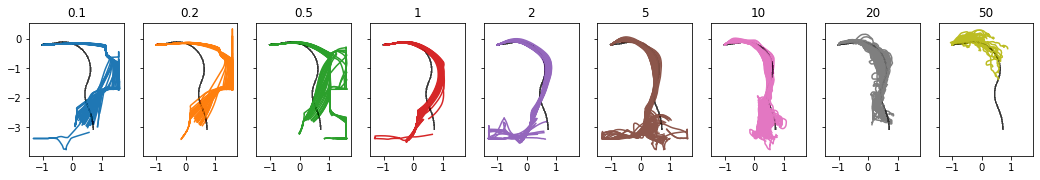

In [18]:
fig, axes = plt.subplots(1, 9, figsize=(18, 5), sharex=True, sharey=True)

for ax, rot_coeff, traintrial, testtrial, color in zip(axes, ls_rot_coeff, data_path_train, data_path_test, ls_color):
    for train, test in zip(traintrial, testtrial):
        ax.plot(*train, c='k', alpha=0.01)
        ax.plot(*test, c=color)

    ax.set_aspect('equal')
    ax.set_title(rot_coeff)

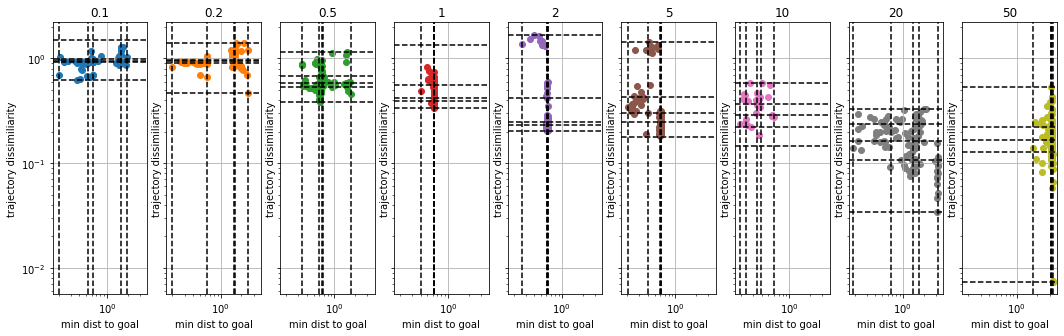

In [19]:
fig, axes = plt.subplots(1, n_condition, sharex=True, sharey=True, figsize=(18, 5))

quantile_mindist_test2goal[model_name], quantile_dsim_test2train[model_name] = [], []
for dsim, dtmd, val, ax, color in zip(data_dsim_test2train, data_mindist_test2goal, ls_rot_coeff, axes.flatten(), ls_color):
    quantile_mindist_test2goal[model_name].append(np.nanquantile(dtmd, [0, 0.25, 0.5, 0.75, 1]))
    quantile_dsim_test2train[model_name].append(np.quantile(dsim, [0, 0.25, 0.5, 0.75, 1]))
    
    [ax.axvline(mdq, color='k', ls='dashed') for mdq in quantile_mindist_test2goal[model_name][-1]]    
    [ax.axhline(mdq, color='k', ls='dashed') for mdq in quantile_dsim_test2train[model_name][-1]]
    ax.scatter(dtmd, dsim, color=color)
    
    ax.set_xlabel('min dist to goal')
    ax.set_ylabel('trajectory dissimiliarity')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title(val)
    ax.grid()

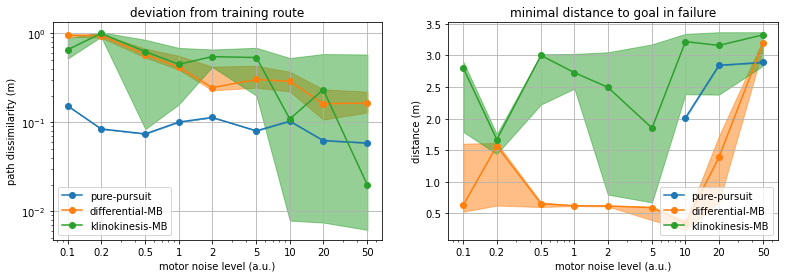

In [37]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(13, 4))

for ax, q in zip(axes, (quantile_dsim_test2train, quantile_mindist_test2goal)):
    for model_name, color in zip(('pure-pursuit', 'differential-MB', 'klinokinesis-MB'), ls_color):
        y = np.array(q[model_name])
        ax.plot(ls_rot_coeff, y.T[2], marker='o', color=color, label=model_name)
        ax.fill_between(ls_rot_coeff, y.T[1], y.T[3], color=color, alpha=0.5)
    
for ax, title in zip(axes, ('deviation from training route', 'minimal distance to goal in failure')):
    ax.set_title(title)
    ax.set_xscale('log')
    ax.set_xlabel('motor noise level (a.u.)')
    ax.set_xticks(ls_rot_coeff, labels=ls_rot_coeff)
    ax.legend()
    ax.grid()
    

axes[0].set_ylabel('path dissimilarity (m)')
axes[1].set_ylabel('distance (m)')
    
axes[0].set_yscale('log')

for this fixed route, the optimal rot_coeff for pure-pursuit is 5, and that for differential_MB is 10

This is a guidance for us to choose the hyperparameter, balancing moving forward and oscillation, but we would want this value to work robustly for all other scenarios.

/home/yihelu/miniconda3/envs/python3.8/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/yihelu/miniconda3/envs/python3.8/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


Text(0.5, 1.0, 'time of entering catchment')

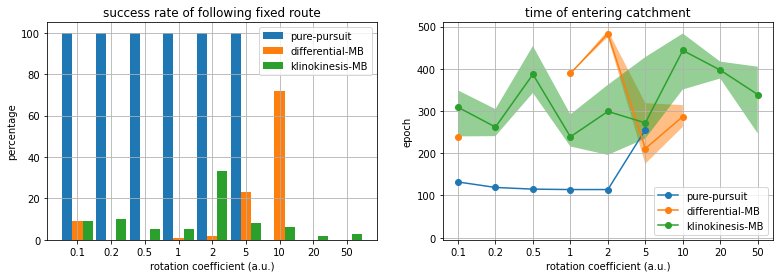

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(13, 4))

for (key, color, offset) in zip(('pure-pursuit', 'differential-MB', 'klinokinesis-MB'), ls_color, (-0.3, 0, 0.3)):
    data = np.reshape(data_success_time[key], (n_condition, -1))
    axes[0].bar(np.arange(n_condition) + offset, (1 - np.count_nonzero(np.isnan(data), axis=1) / n_trial) * 100, 
                width = 0.3, label=key)
    lo, mid, hi = np.nanquantile(data, (0.25, 0.5, 0.75), axis=1)
    axes[1].plot(np.arange(n_condition), mid, marker='o', label=key)
    axes[1].fill_between(np.arange(n_condition), lo, hi, alpha=0.5)
    
# axes[1].axhline(124, label='training', ls='dotted', color='k')

for ax in axes:
    ax.set_xticks(np.arange(n_condition), ls_rot_coeff)
    ax.grid()
    ax.legend()
    ax.set_xlabel('rotation coefficient (a.u.)')
    
axes[0].set_ylim(0, 105)
axes[1].set_ylim(-5, 510)
    
axes[0].set_ylabel('percentage')
axes[1].set_ylabel('epoch')

axes[0].set_title('success rate of following fixed route')
axes[1].set_title('time of entering catchment')